<a href="https://colab.research.google.com/github/ykitaguchi77/ImageProcessing/blob/master/Eye_crop1.4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#顔の画像から目を検出して切り抜くスクリプト
・Haarcascade_eyeを使用<br>
・目が検出できないものはskipする<br>
・検出された目周囲の画像を縦横とも1.1倍の幅で切り抜く
・切り取った画像を250px*250pxにresizeする<br>
・対応表をCSV形式で出力（連番、左右、元フォルダ、元画像名）

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import csv
from random import randint
from time import sleep

import glob
import random
from PIL import Image
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode

#Google colabをマウント

In [2]:
'''
変換前
--in-----1-----abc.jpg
      |    |--def.jpg
      |
      |-2-----ghi.jpg     
           |--jkl.jpg

変換後
--out-------1.jpg
        |--2,jpg        
        |--3.jpg
        |--4.jpg
'''

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#元画像フォルダ
in_path = '/content/drive/My Drive/Deep_learning/eyelid_images/in'

#保存先フォルダ
out_path = '/content/drive/My Drive/Deep_learning/eyelid_images/out'

#CSVファイルのフォルダ
csv_path = '/content/drive/My Drive/Deep_learning/eyelid_images/eyelid_images.csv'


#Haarcascadeを指定

In [0]:
# カスケードファイルのパス
eye_cascade_path = '/content/drive/My Drive/Deep_learning/haarcascade_eye.xml'

# カスケード分類器の特徴量取得
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)

#画像を切り抜いて連番で出力、対応表出力
12時間で60000枚を処理するのは不可能（1秒間に3枚として12000枚 =フォルダ1600個ぐらいが限界）<br>
→1回のセッションでフォルダ1000個ずつを処理することとする

In [7]:
#処理するDirectoryの設定
directory = os.listdir(in_path)
print(len(directory))

#ここにフォルダ番号を記載する (ex. [0:999])
processing_directory = directory[4000:4999]
print(processing_directory)

8196
['4205', '4199', '4207', '4211', '4210', '4208', '4209', '4212', '4213', '4214', '4216', '4215', '4225', '4228', '4220', '4231', '4226', '4218', '4227', '4224', '4222', '4223', '4217', '4230', '4221', '4219', '4229', '4238', '4234', '4240', '4232', '4235', '4243', '4237', '4239', '4236', '4244', '4241', '4233', '4242', '4248', '4250', '4245', '4251', '4247', '4249', '4253', '4252', '4246', '4254', '4255', '4256', '4257', '4273', '4264', '4258', '4266', '4265', '4261', '4260', '4270', '4259', '4272', '4271', '4263', '4269', '4268', '4262', '4267', '4277', '4279', '4278', '4275', '4276', '4280', '4274', '4281', '4283', '4284', '4282', '4289', '4288', '4293', '4291', '4286', '4287', '4294', '4290', '4285', '4292', '4298', '4297', '4300', '4299', '4296', '4295', '4309', '4304', '4305', '4306', '4308', '4307', '4301', '4310', '4302', '4303', '4311', '4312', '4313', '4315', '4316', '4314', '4318', '4317', '4319', '4320', '4321', '4323', '4325', '4328', '4333', '4331', '4332', '4324', '4

In [8]:
#処理時間の計測
start = time.time()

with open(csv_path, 'a', newline='') as f:  #a:追記モード
        writer = csv.writer(f)
        fieldnames = ['Number', 'Folder', 'FileName']       
        writer.writerow(['Folder', 'Image_num', 'side (R:0, L:1)', 'ImageName', 'Number'])  #header
        
        k=0
        for i in processing_directory:  #フォルダ数の分だけ
              file = os.listdir(in_path + '/' + i)

              l=0
              for j in file:
                    l+=1
                    print(str(l))
                    print('')
                    img = cv2.imread(in_path + '/' + i + '/' + j) 
                    img2 = img.copy()

                    # 画像グレースケール化
                    grayscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

                    #300pix以上のもので目に見えるものを抽出
                    eye_list = eye_cascade.detectMultiScale(grayscale_img, minSize=(300, 300))
                    print('image path = '+ in_path + '/' + i + '/' + j )
                    
                    # 眼検出判定
                    if len(eye_list) >= 1:
                        '''
                        print('目が' + str(len(eye_list)) +'個検出されました')
                        '''
                        pass
                    else:
                        '''
                        print("eye detection error")
                        '''
                        break

                    #画像の切り抜きと保存（連番にする）
                    
                    m=0
                    for (ex, ey, ew, eh) in eye_list:
                        m+=1
                        #print("[ex,ey] = %d,%d [ew,eh] = %d,%d" %(ex, ey, ew, eh))
                        try:
                          cv2.rectangle(img2, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)
                          img_cropped = img[int(ey-0.1*eh): int(ey+1.1*eh), int(ex-0.1*ew): int(ex+1.1*ew)]
                          img_resized = cv2.resize(img_cropped,(250,250)) #1辺250pixにresize 
                          #x, y = random.randint(0,27), random.randint(0,27) #ランダムな位置で224pixに切り取る
                          #img_randcrop = img_resized[y: y+223, x: x+223]
                        except:
                            pass

                        if ex <= 600:
                            side = 0 #600ピクセル目より左にあるのは右眼
                        else:
                            side = 1 #600ピクセル目より右にあるのは左眼
                        
                        '''
                        print('/content/drive/My Drive/Deep_learning/eyelid_images/out/'+str(i)+'-' + str(l) + '-' + str(side)+ '.jpg')
                        '''

                        #保存する際のよくわからないエラーをskipする
                        try:
                            cv2.imwrite('/content/drive/My Drive/Deep_learning/eyelid_images/out/'+str(i)+'-' + str(l) + '-' + str(side)+ '.jpg', img_resized)
                            #対応表の作成
                            writer.writerow([str(i), str(l),side, str(j), str(k+1)])
                            k+=1
                        except:
                            pass

print('Process done!!')
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")


1

image path = /content/drive/My Drive/Deep_learning/eyelid_images/in/4205/20180807110247_眼位_O_0_94dd742af6c29dd86e6ac801196711d68c2e574aff1019e7ecdbf5104c776377.jpg
1

image path = /content/drive/My Drive/Deep_learning/eyelid_images/in/4199/20110623000000_眼位_O_0_e89d060ecc1767a0ec6e88c4f3aa2372bbb3cea8b5714dda9d785d49692542e2.jpg
2

image path = /content/drive/My Drive/Deep_learning/eyelid_images/in/4199/20110623000000_眼位_O_0_631fcf2f2a719d942fa600ba194e1719603881ca1779a12bf4d2289bf5b213d7.jpg
3

image path = /content/drive/My Drive/Deep_learning/eyelid_images/in/4199/20110623000000_眼位_O_0_d0eaaf978b865b06c5debcc9ef65b7d56e837a7afb30f81e0d6c4803f4ead523.jpg
1

image path = /content/drive/My Drive/Deep_learning/eyelid_images/in/4207/20090930143802_眼位_O_0_fa2cd62c79c76c9dbc671c8882cd14e094c93a2d434bad91c0b55fb810161d26.jpg
2

image path = /content/drive/My Drive/Deep_learning/eyelid_images/in/4207/20090930143802_眼位_O_0_b5eb2cfb5d35c7d423a32651a9a31dc5e4a3573558e7c83e3ef69c6012db0773.jp

#切り取られた図を表示してみる

['.ipynb_checkpoints', '1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg']


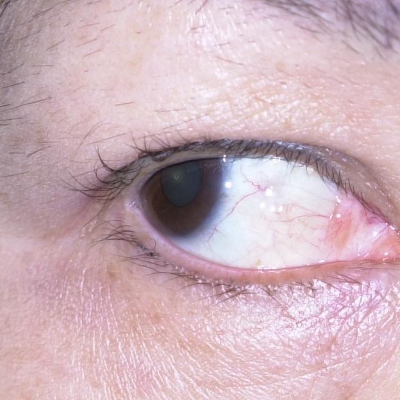

In [0]:
img_list = os.listdir('/content/drive/My Drive/Deep_learning/eyelid_images/out')
print(img_list)
img = cv2.imread('/content/drive/My Drive/Deep_learning/eyelid_images/out/'+img_list[12])


#アスペクト比を維持したまま横を400pixelに縮小する
def scale_to_width(img, width):
    scale = width / img.shape[1]
    return cv2.resize(img, dsize=None, fx=scale, fy=scale)
dst = scale_to_width(img, 400)

#図を表示する
cv2_imshow(dst)